This notebook is used after training to load, explore, and validate the models created during training. Please run `leaf-setup.ipynb` and `run.sh` first to create the models.

In [10]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

import cv2

import os
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf

print("Tensorflow",tf.__version__)
print("Keras",keras.__version__)

Tensorflow 1.8.0
Keras 2.1.6


## Load the model and create a graph

In [2]:
runmodel="MNET"
## need relu6 for MNET models, so for now, hard code it before loading model
from keras.utils.generic_utils import CustomObjectScope
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    model = keras.models.load_model("leaf.%s.h5" % runmodel)

Create a graph for exploration with Tensorboard.

In [3]:
sess = K.get_session()
writer = tf.summary.FileWriter("log-%s" % runmodel, sess.graph)
writer.close()

Get the classes from the training data generator

In [5]:
train_dir = "data/train"
validation_dir = "data/validation"
test_dir = "data/test"
image_size=224
batch_size=32

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

num_classes = len(train_generator.class_indices)
classes = {}
for key, val in train_generator.class_indices.items():
    classes[val] = key
input_shape = train_generator.image_shape

Found 21285 images belonging to 159 classes.


## Field test around Harvard

In [22]:
#
# show a sample image for a tree from the validation set
#
def showsample(species, show=True):
    dirp = "data/validation/%s" % species
    imgfile = os.listdir(dirp)[0]
#     print(imgfile)
    img = cv2.imread("%s/%s" % (dirp, imgfile), cv2.IMREAD_GRAYSCALE)
#     plt.figure()
    plt.imshow(img, cmap='gray')
    if show: plt.show()

In [8]:
def predict_image(testimage):
    img = cv2.imread(testimage, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    imgx = np.reshape(img/255, (1, 224, 224, 1))
    
    evaltest =  model.predict(imgx)
    for i in np.argsort(-evaltest)[0][:5]:
        print(i, classes[i], evaltest[0,i])
        showsample(classes[i])

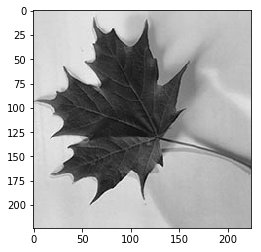

99 platanus_occidentalis 0.65430933


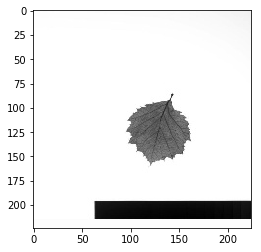

4 acer_palmatum 0.2700164


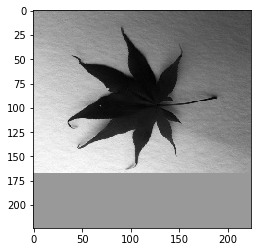

6 acer_platanoides 0.04899015


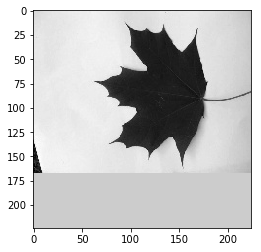

98 platanus_acerifolia 0.009546419


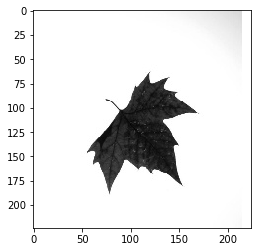

10 acer_saccharum 0.005058223


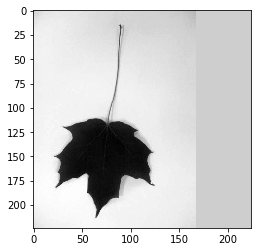

In [11]:
predict_image("../acer-platanoides.jpg")

## Evaluate the model

In [12]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 2657 images belonging to 159 classes.


### Single Prediction

To demonstrate the testing visually, I will load one image from the testing set and show the top five predictions. The first image is the test image. The next images comprise a sample for each prediction.

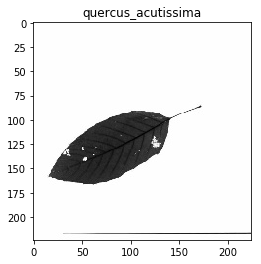

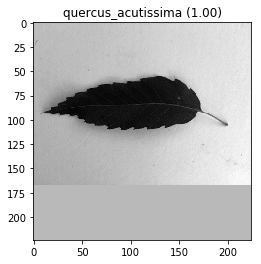

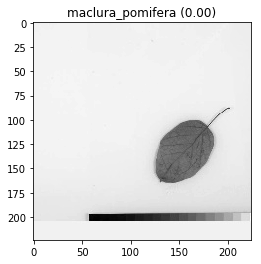

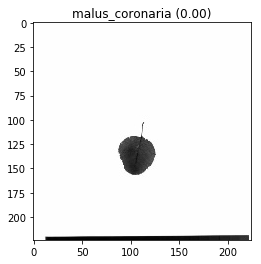

In [36]:
for xbatch, ybatch in test_generator:
    ptest =  model.predict(xbatch)
    for x, y, p in zip(xbatch, ybatch, ptest):
#         print(x.shape)
        tree = np.argmax(y)
        plt.imshow(x.reshape(224, 224), cmap='gray')
        plt.title(classes[tree])
        plt.show()

#         print(p)
        for i in np.argsort(-p)[:3]:
#             print("Predict",p[i], classes[i])
            plt.title("%s (%0.2f)" % (classes[i], p[i]))
            showsample(classes[i])
        break
    break

### Correct top N predictions

In [16]:
def predict_top(topnum, samples = 200):
    numright = 0
    numtot = 0
    for xbatch, ybatch in test_generator:
        if numtot > samples: break
        ptest =  model.predict(xbatch)
        for x, y, p in zip(xbatch, ybatch, ptest):
            numtot += 1
            if numtot > samples: break
            tree = np.argmax(y) # correct tree
            for i in np.argsort(-p)[:topnum]:
                if i == tree:
                    numright += 1
                    break
    return numright / numtot

In [20]:
for top in range(1,6):
    print(top, predict_top(top, 500))

1 0.9241516966067864
2 0.9820359281437125
3 0.9920159680638723
4 0.9900199600798403
5 0.9920159680638723


### Prediction Certainty

I also wanted to explore the "certainty" of predictions. Each prediction carries with it a number between 0 and 1 roughly corresponding to the certainty of the model's prediction. For this analysis, I look at 500 samples and split them into groups of right and wrong predictions. Then each group's certainty is plotted as a histogram.

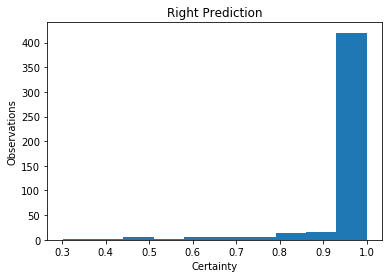

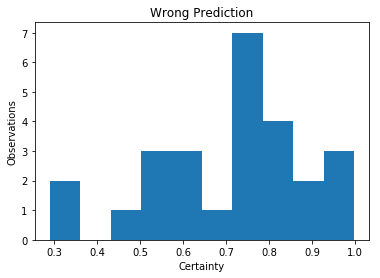

In [33]:
samples = 500
right = []
wrong = []
numtot = 0
for xbatch, ybatch in test_generator:
    if numtot > samples: break
    ptest =  model.predict(xbatch)
    for x, y, p in zip(xbatch, ybatch, ptest):
        numtot += 1
        if numtot > samples: break
        tree = np.argmax(y)
        ptree = np.argmax(p)
        if tree == ptree:
            right.append(p[ptree])
        else:
            wrong.append(p[ptree])
            
plt.hist(right)
plt.xlabel('Certainty')
plt.ylabel('Observations')
plt.title('Right Prediction')
plt.show()

plt.hist(wrong)
plt.xlabel('Certainty')
plt.ylabel('Observations')
plt.title('Wrong Prediction')
plt.show()

As expected, for the group where the top prediction was correct, most observations fell over the 90% certainty. For the group with the wrong top prediction, the certainty was generally lower, although there were some observations with over 90% certainty. This is probably due to some trees being virtually indistinguishable based solely on leaves.

To illustrate this I will display the images for an incorrect prediction.

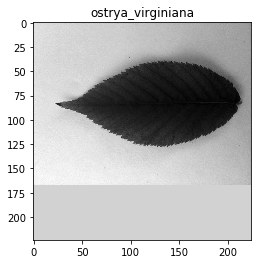

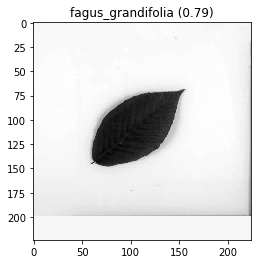

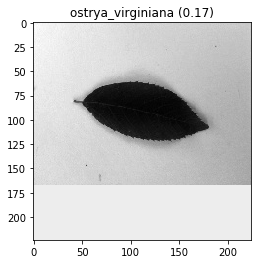

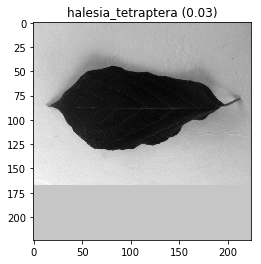

In [41]:
stop = False
for xbatch, ybatch in test_generator:
    ptest =  model.predict(xbatch)
    for x, y, p in zip(xbatch, ybatch, ptest):
        tree = np.argmax(y)
        ptree = np.argmax(p)
        if tree != ptree:
            plt.imshow(x.reshape(224, 224), cmap='gray')
            plt.title(classes[tree])
            plt.show()
            for i in np.argsort(-p)[:3]:
                plt.title("%s (%0.2f)" % (classes[i], p[i]))
                showsample(classes[i])
            stop = True
            break
        if stop: break
    if stop: break